In [1]:
from tqdm import tqdm
import json
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sys.path.insert(0, os.path.abspath("../"))

In [2]:
from mrcad.design import Design
from mrcad.render_utils import Collinear
from experiments.data_conversion_utils import get_design_from_record

In [3]:
def executeActions(actions):
    """
    Executes a list of ACTIONS and returns the geometries (points and curves) that are created/ modified by those actions.

    Note: there are slight discrepencies between this and the JS executing function.
    """

    pt_id_ctr = 1
    points = {}
    curves = []
    cur_geometries = set()

    def add_geometry(geometry):
        geometry_str = str(geometry)

        if geometry_str in cur_geometries:
            return False

        else:
            cur_geometries.add(geometry_str)
            if geometry["name"] == "pt":
                nonlocal pt_id_ctr
                pt_id = "pt_" + str(pt_id_ctr)
                points[pt_id] = geometry
                pt_id_ctr += 1
            else:
                curves.append(geometry)
            return True

    def update_geometry_rep(geometry_old, geometry_new):

        geometry_str_old = str(geometry_old)
        if geometry_str_old not in cur_geometries:
            return False
        else:
            cur_geometries.remove(geometry_str_old)
            cur_geometries.add(str(geometry_new))
            return True

    def get_line_repr_from_action(line_content):
        pt1_coord_i, pt1_coord_j = line_content[1]
        pt2_coord_i, pt2_coord_j = line_content[2]

        pt1_id = next(
            (
                pt_id
                for pt_id, pt_obj in points.items()
                if pt_obj["i"] == pt1_coord_i and pt_obj["j"] == pt1_coord_j
            ),
            None,
        )
        pt2_id = next(
            (
                pt_id
                for pt_id, pt_obj in points.items()
                if pt_obj["i"] == pt2_coord_i and pt_obj["j"] == pt2_coord_j
            ),
            None,
        )

        if pt1_id and pt2_id:
            return {"name": "line", "pt1": pt1_id, "pt2": pt2_id}
        return None

    def get_arc_repr_from_action(arc_content):
        curve_name = arc_content[0]
        pt1_coord_i, pt1_coord_j = arc_content[1]
        pt2_coord_i, pt2_coord_j = arc_content[2]
        pt3_coord_i, pt3_coord_j = arc_content[3]

        pt1_id = next(
            (
                pt_id
                for pt_id, pt_obj in points.items()
                if pt_obj["i"] == pt1_coord_i and pt_obj["j"] == pt1_coord_j
            ),
            None,
        )
        pt2_id = next(
            (
                pt_id
                for pt_id, pt_obj in points.items()
                if pt_obj["i"] == pt2_coord_i and pt_obj["j"] == pt2_coord_j
            ),
            None,
        )
        pt3_id = next(
            (
                pt_id
                for pt_id, pt_obj in points.items()
                if pt_obj["i"] == pt3_coord_i and pt_obj["j"] == pt3_coord_j
            ),
            None,
        )

        if pt1_id and pt2_id and pt3_id:
            if curve_name == "arc_3pt":
                if (pt1_id != pt2_id) and (
                    pt2_id != pt3_id
                ):  # only add curve if distinct consecutive points
                    return {
                        "name": "arc_3pt",
                        "start": pt1_id,
                        "mid": pt2_id,
                        "end": pt3_id,
                    }
        return None

    def do_mk_curve_action(action):
        curve_content = action[1]
        curve_kind = curve_content[0]

        curve_repr = None
        if curve_kind == "line":
            curve_repr = get_line_repr_from_action(curve_content)
        elif curve_kind == "arc_3pt" or curve_kind == "arc_cen":
            curve_repr = get_arc_repr_from_action(curve_content)

        if curve_repr:
            return add_geometry(curve_repr)
        return False

    def do_mk_pt_action(action):
        coord_i = action[1]
        coord_j = action[2]
        point = {"name": "pt", "i": coord_i, "j": coord_j}
        return add_geometry(point)

    def remove_geometry(geometry):

        geometry_str = str(geometry)
        if geometry_str not in cur_geometries:
            return False
        cur_geometries.remove(geometry_str)

        if geometry["name"] == "pt":
            pt_id_to_remove = [
                pt_id for pt_id, val in points.items() if str(val) == geometry_str
            ]
            for pt_id in pt_id_to_remove:
                del points[pt_id]
                # propagate deletion to geometries involving that point
                # Identify curves that use the deleted point
                curve_indices_to_remove = [
                    c_id
                    for c_id, curve in enumerate(curves)
                    if any(val == pt_id for val in curve.values())
                ]

                for index in sorted(curve_indices_to_remove, reverse=True):
                    del curves[index]
        else:
            curves[:] = [curve for curve in curves if str(curve) != geometry_str]
        return True

    def fuse_points(pt_id_to_delete, pt_id_to_join):
        # moving pt_id_to_move on top of pt_id_to_join
        # will delete pt_id_to_move and preserve pt_id_to_join

        # Assume 'curves' is a list of dictionaries representing curves
        # and 'points' is a dictionary of points
        curves_to_delete = []

        executable = False
        # update point id in all curves
        for c_id in range(0, len(curves)):
            the_old_curve = curves[c_id].copy()
            the_curve = curves[c_id]
            changed = False
            # iterate over ids of all points and swap if it's being fused
            #             for key in list(the_curve.keys()): # changed mon 13 nov

            for key in list(the_old_curve.keys()):
                if the_curve[key] == pt_id_to_delete:

                    the_curve[key] = pt_id_to_join
                    changed = True

            if changed:
                executable = update_geometry_rep(the_old_curve, the_curve)

                # if the curve is now invalid, delete
                if the_curve["name"] == "arc_3pt":
                    if (the_curve["start"] == the_curve["mid"]) or (
                        the_curve["mid"] == the_curve["end"]
                    ):
                        # delete curve
                        curves_to_delete.append(c_id)
                #                         remove_geometry(the_curve)
                elif the_curve["name"] == "line":
                    if the_curve["pt1"] == the_curve["pt2"]:
                        # delete curve
                        #                         remove_geometry(the_curve)
                        curves_to_delete.append(curves[c_id])

        for curve in curves_to_delete:
            executable = remove_geometry(curve)

        # Delete the point that's being moved
        executable = remove_geometry(
            {
                "name": "pt",
                "i": points[pt_id_to_delete]["i"],
                "j": points[pt_id_to_delete]["j"],
            }
        )

        #         if pt_id_to_delete in points:
        #             del points[pt_id_to_delete]
        return executable

    executable_actions = []
    for action in actions:

        if action == []:
            continue

        if action[0] == "mk_pt":
            executable = do_mk_pt_action(action)

        elif action[0] == "del_pt":
            coord_i = action[1]
            coord_j = action[2]
            geometry = {"name": "pt", "i": coord_i, "j": coord_j}
            executable = remove_geometry(geometry)
        elif action[0] == "mv_pt":
            coord_i1 = action[1]
            coord_j1 = action[2]
            coord_i2 = action[3]
            coord_j2 = action[4]

            # see if point at exists at origin
            #             for pt_id_to_move, pt_move_content in points.copy().items():
            for pt_id_to_move in list(points.keys()):
                pt_move_content = points[pt_id_to_move]
                if (
                    pt_move_content["i"] == coord_i1
                    and pt_move_content["j"] == coord_j1
                ):

                    # see if point at exists at destination
                    pt_id_to_join = None
                    for pt_id, pt_join_content in points.items():
                        if (
                            pt_join_content["i"] == coord_i2
                            and pt_join_content["j"] == coord_j2
                        ):
                            #                             assert pt_id_to_join == None
                            pt_id_to_join = pt_id

                    # if it does, fuse the points
                    if pt_id_to_join != None:
                        executable = fuse_points(pt_id_to_move, pt_id_to_join)
                    # otherwise,
                    else:
                        geometry_old = {
                            "name": "pt",
                            "i": points[pt_id_to_move]["i"],
                            "j": points[pt_id_to_move]["j"],
                        }
                        geometry_new = {"name": "pt", "i": coord_i2, "j": coord_j2}
                        points[pt_id_to_move]["i"] = coord_i2
                        points[pt_id_to_move]["j"] = coord_j2
                        executable = update_geometry_rep(geometry_old, geometry_new)
                        break

        elif action[0] == "mk_curve":
            executable = do_mk_curve_action(action)
        elif action[0] == "rm_curve":
            curve_content = action[1]
            curve_kind = curve_content[0]
            if curve_kind == "line":
                executable = remove_geometry(get_line_repr_from_action(curve_content))
            elif curve_kind == "arc_3pt":
                executable = remove_geometry(get_arc_repr_from_action(curve_content))

        if executable:
            executable_actions.append(action)

    return {
        "points": points,
        "curves": curves,
    }, executable_actions

In [4]:
executions_df = pd.read_csv("../tests/df_executions_mcad-async-internal-pilot-go.csv")

In [7]:
df_list = []
for i, row in tqdm(executions_df.iterrows()):
    next_design = get_design_from_record(eval(row.jsGeometries))
    current_design = get_design_from_record(executeActions(eval(row.context)['prevActions'])[0])
    
    try:
        df_list.append((
            row.targetId, row.generation, 
            next_design.chamfer_distance(current_design), 
            next_design.similarity(current_design), 
            next_design.constraint_score(current_design)
            ))
    except Collinear:
        pass

df = pd.DataFrame(df_list, columns=["targetId", "generation", "chamfer_distance", "similarity", "constraint_score"])

86it [00:02, 36.97it/s]


<Axes: xlabel='generation', ylabel='similarity'>

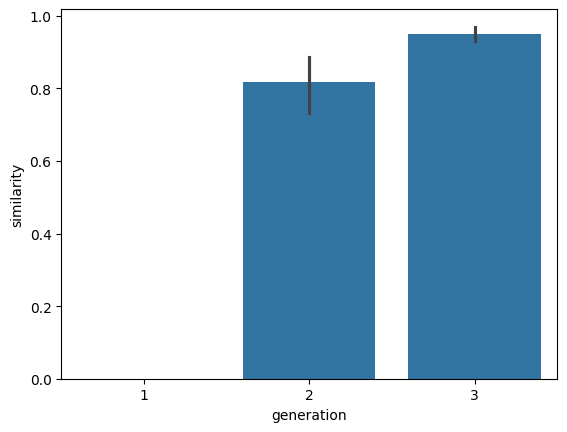

In [11]:
sns.barplot(data=df, x="generation", y="similarity")

<Axes: xlabel='generation', ylabel='constraint_score'>

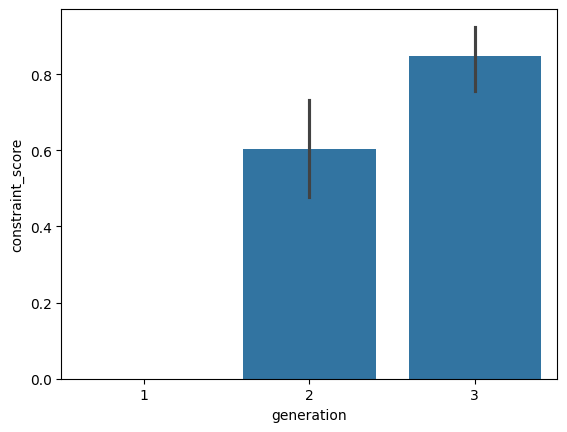

In [12]:
sns.barplot(data=df, x="generation", y="constraint_score")

<Axes: xlabel='generation', ylabel='chamfer_distance'>

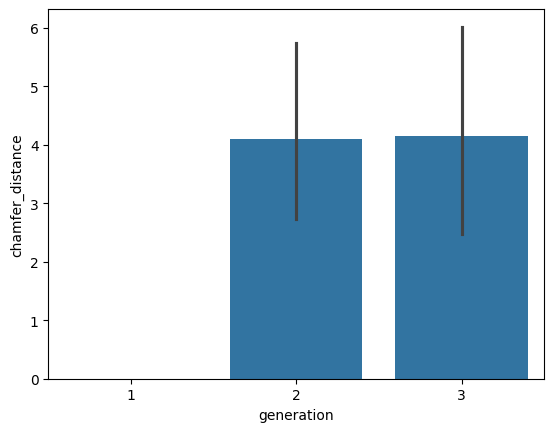

In [13]:
sns.barplot(data=df, x="generation", y="chamfer_distance")